In [51]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
import chaosmagpy as cp


from jerks import jerks

# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat
    


# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)



# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]
coeffs = arrays['gnm'][:,:].T
              
time = arrays['timers'].flatten()              
index = np.argmin(abs(time-jerk_times[8]))

coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)


radius = 6371.
theta = 80
phi = 65
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)

              
              
              


In [52]:
run_components=[0,1,2] #compute for X
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=int )
median_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=int )

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 1000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    delta_hist_save[i,:] = delta_slope[:]
    av_hist_save[i,:] = AV[:]
    median_hist_save[i,:] = MEDIAN[:]

    print(i, Acceptance_rates)
    
    
    

0 [38.63940048 36.41724014  3.07397485  3.07529664]
1 [72.12860107 45.11403656  5.57004023  5.56736803]
2 [69.90979767 47.68632126  5.59226751  5.59439707]


#### Display the average absolute gradient (stacked over the 3 components):

Text(0.5, 1.0, 'Stacked data')

<Figure size 432x288 with 0 Axes>

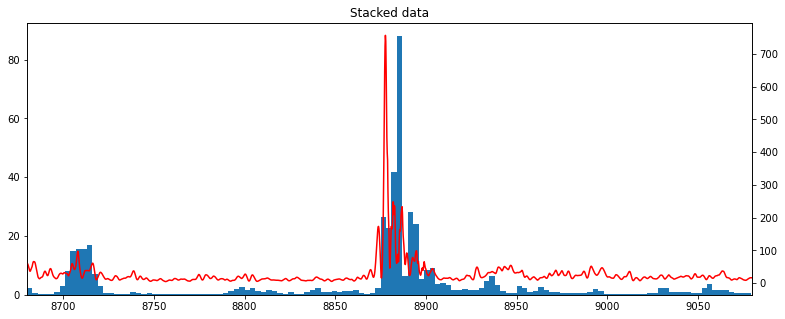

In [53]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, delta_hist_save[:,:].sum(axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')


In [ ]:
# Comments. The peak prior to 8800 seems to appear due to the specific choice of 10% error. 
At 15% it disappears. I've checked the calculation of the gradient and it's correct.


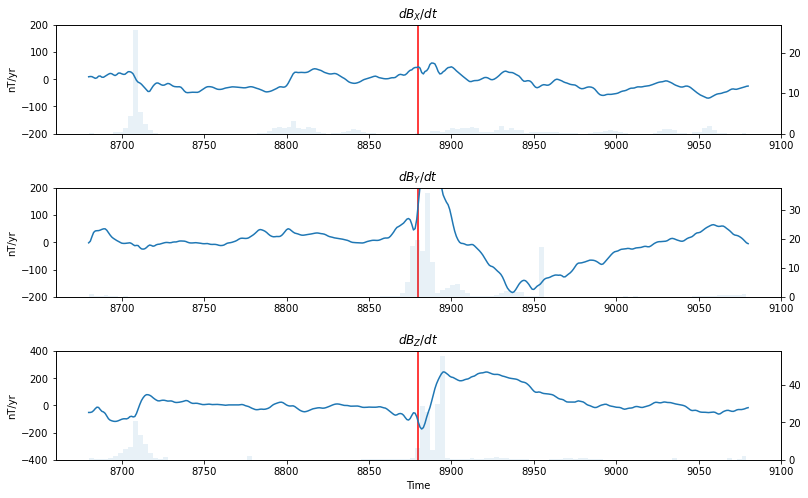

In [42]:
theta = 80
phi = 65

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
ax1b = ax1.twinx()
ax1b.bar(left_edges, delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)

a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
ax2b = ax2.twinx()
ax2b.bar(left_edges, delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
ax3b = ax3.twinx()
ax3b.bar(left_edges, delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




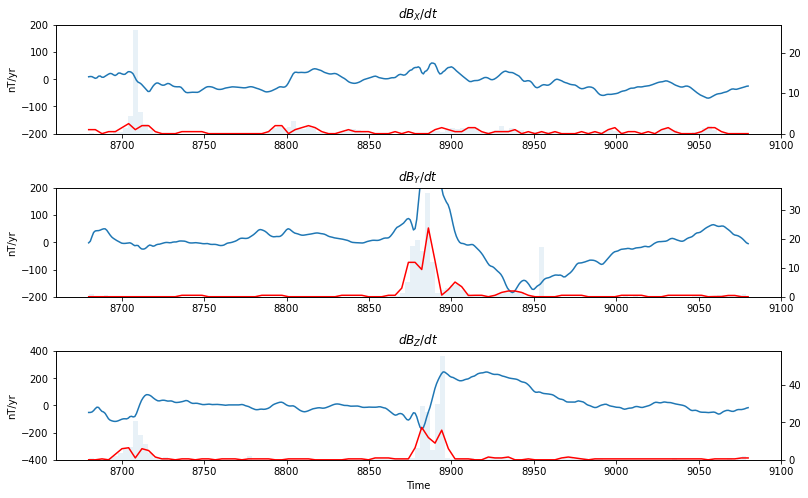

In [43]:
t = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size)


theta = 80
phi = 65

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
#ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
ax1b = ax1.twinx()
ax1b.bar(left_edges, delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)
ax1b.plot( t, abs(np.gradient(np.gradient(median_hist_save[0,:],t))), 'r')

a=200
#ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
ax2b = ax2.twinx()
ax2b.bar(left_edges, delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)
ax2b.plot( t, abs(np.gradient(np.gradient(median_hist_save[1,:],t))), 'r')

a=400
#ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
ax3b = ax3.twinx()
ax3b.bar(left_edges, delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]),alpha=0.1)
ax3b.plot( t, abs(np.gradient(np.gradient(median_hist_save[2,:],t))), 'r')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)






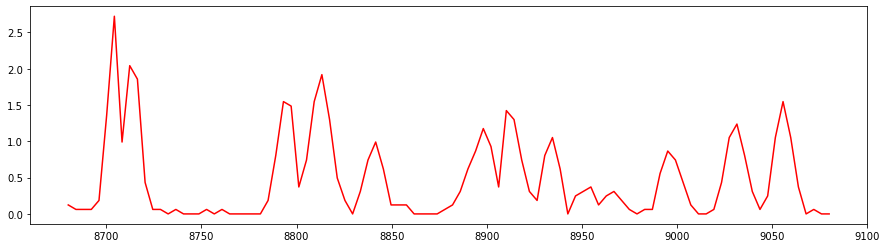

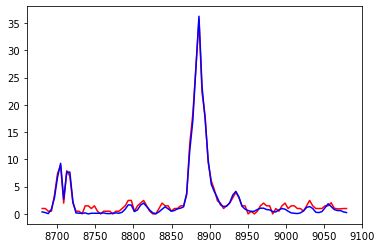

In [50]:
t = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size)
plt.figure( figsize=(15,4))
plt.plot( t, abs(np.gradient(np.gradient(av_hist_save[0,:],t))), 'r')

plt.figure()
stacked_av = abs(np.gradient(np.gradient(av_hist_save[0,:],t))) + abs(np.gradient(np.gradient(av_hist_save[1,:],t))) + abs(np.gradient(np.gradient(av_hist_save[2,:],t)))

stacked_median = abs(np.gradient(np.gradient(median_hist_save[0,:],t))) + abs(np.gradient(np.gradient(median_hist_save[1,:],t))) + abs(np.gradient(np.gradient(median_hist_save[2,:],t)))
plt.plot( t, stacked_median, 'r')
plt.plot( t, stacked_av, 'b')



(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([8680, 8683, 8686, 8689, 8692, 8695, 8698, 8701, 8704, 8707, 8710,
        8713, 8716, 8719, 8722, 8725, 8728, 8731, 8734, 8737, 8740, 8743,
        8746, 8749, 8752, 8755, 8758, 8761, 8764, 8767, 8770, 8773, 8776,
        8779, 8782, 8785, 8788, 8791, 8794, 8797, 8800, 8803, 8806, 8809,
        8812, 8815, 8818, 8821, 8824, 8827, 8830, 8833, 8836, 8839, 8842,
        8845, 8848, 8851, 8854, 8857

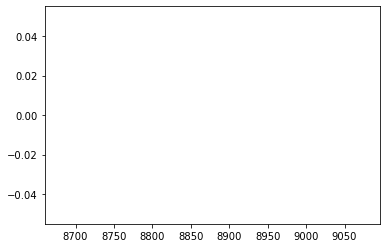

In [39]:
plt.hist( abs(np.gradient(np.gradient(median_hist_save[0,:],t))), bins=time_intervals_edges[:-1])


In [11]:
q1 = ( q[q[:,0] == 10,1] )

In [16]:
q1.max(), q1.min()



15.720089791670944

In [33]:
np.mean(q1[q1 < 100]), np.median(q1), len(q1)

(20.332038858859427, 15.720089791670944, 3033)

In [25]:
np.median(q1) * 3033/10000

4.767903233813797

(array([2.615e+03, 2.040e+02, 6.900e+01, 3.800e+01, 1.800e+01, 1.200e+01,
        6.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 1.300e+01, 7.000e+00,
        3.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

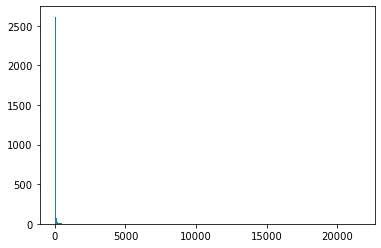

In [30]:
plt.hist(q1, bins=500)

In [28]:
? plt.hist

Signature:
 plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*.  The return value is a tuple
(*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
*patches1*, ...]) if the input contains multiple data.  See the
documentation of the *weights* parameter to draw a histogram of
already-binned data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported.

The *bins*, *range*, *weights*, and *density* parameters behave as in
`numpy.histogram`.

